<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/x4_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Networks

In [1]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

%matplotlib inline

### 4.01: Build CNN for image classification problem

#### Data

In [2]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transformation)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transformation)

len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [3]:
idx = list(range(len(train_data)))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=0)
len(train_idx), len(val_idx)

(40000, 10000)

In [4]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [5]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

#### Network

* Input shape is (3, 32, 32) -- channel first

In [6]:
class ImageClassifierNet(nn.Module):

  def __init__(self):
    super(ImageClassifierNet, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 10, 3, 1, padding=1),    # (10, 32, 32)
      nn.ReLU(),
      nn.MaxPool2d(2, 2)                    # (10, 16, 16)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(10, 20, 3, 1, padding=1), # (20, 16, 16)
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                  # (20, 8, 8)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(20, 40, 3, 1, padding=1), # (40, 8, 8)
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                  # (40, 4, 4)
    )
    self.linear1 = nn.Sequential(
        nn.Linear(40 * 4 * 4, 100),
        nn.Dropout(0.2),
        nn.ReLU()
    )
    self.linear2 = nn.Linear(100, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1, 40 * 4 * 4)
    x = self.linear1(x)
    x = F.log_softmax(self.linear2(x), dim=1)
    return x

net1 = ImageClassifierNet()
print(net1)

ImageClassifierNet(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=640, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)


#### Training Loop

In [7]:
def train(net, dev, train_dl, val_dl, num_epochs=50, lr=1e-3):
  losses = []
  params = filter(lambda p: p.requires_grad, net.parameters())
  optimizer = torch.optim.Adam(params, lr=lr)
  for i in range(num_epochs):
    net.train()
    sum_loss, correct, total = 0, 0, 0
    for x, y in train_dl:
      x, y = x.to(dev), y.to(dev)
      y_ = net(x)
      _, pred = torch.max(y_, 1)
      optimizer.zero_grad()
      loss = F.nll_loss(y_, y)
      loss.backward()
      optimizer.step()
      sum_loss += loss.item() * y.shape[0]
      correct += (pred == y).float().sum()
      total += y.shape[0]
    val_loss, val_acc = evaluate(net, dev, val_dl)
    train_loss = sum_loss / total
    train_acc = correct / total
    print("EPOCH {:d}: train loss: {:.3f}, train_acc: {:.3f}, val loss: {:.3f}, val acc: {:.3f}"
      .format(i+1, train_loss, train_acc, val_loss, val_acc))
    losses.append((i+1, train_loss, train_acc, val_loss, val_acc))
  return losses


def evaluate(net, dev, val_dl):
  net.eval()
  correct, total, sum_loss = 0, 0, 0
  for x, y in val_dl:
    x, y = x.to(dev), y.to(dev)
    y_ = net(x)
    loss = F.nll_loss(y_, y)
    _, pred = torch.max(y_, 1)
    correct += (pred == y).float().sum()
    total += y.shape[0]
    sum_loss += loss.item() * y.shape[0]
  return sum_loss / total, correct / total


In [8]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1.to(dev)

ImageClassifierNet(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=640, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [9]:
losses = train(net1, dev, train_loader, val_loader)

EPOCH 1: train loss: 1.727, train_acc: 0.366, val loss: 1.467, val acc: 0.469
EPOCH 2: train loss: 1.403, train_acc: 0.492, val loss: 1.325, val acc: 0.519
EPOCH 3: train loss: 1.278, train_acc: 0.542, val loss: 1.181, val acc: 0.574
EPOCH 4: train loss: 1.183, train_acc: 0.578, val loss: 1.113, val acc: 0.602
EPOCH 5: train loss: 1.113, train_acc: 0.603, val loss: 1.045, val acc: 0.631
EPOCH 6: train loss: 1.054, train_acc: 0.625, val loss: 1.009, val acc: 0.642
EPOCH 7: train loss: 1.007, train_acc: 0.642, val loss: 0.999, val acc: 0.644
EPOCH 8: train loss: 0.971, train_acc: 0.657, val loss: 0.958, val acc: 0.661
EPOCH 9: train loss: 0.936, train_acc: 0.668, val loss: 0.961, val acc: 0.664
EPOCH 10: train loss: 0.900, train_acc: 0.680, val loss: 0.928, val acc: 0.673
EPOCH 11: train loss: 0.876, train_acc: 0.687, val loss: 0.948, val acc: 0.665
EPOCH 12: train loss: 0.846, train_acc: 0.697, val loss: 0.917, val acc: 0.678
EPOCH 13: train loss: 0.819, train_acc: 0.709, val loss: 0.91

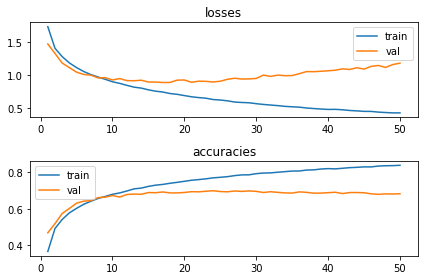

In [10]:
def plot_losses(losses):
  epochs, train_losses, train_accs, val_losses, val_accs = [], [], [], [], []
  for epoch, train_loss, train_acc, val_loss, val_acc in losses:
    epochs.append(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  plt.subplot(2, 1, 1)
  plt.plot(epochs, train_losses, label="train")
  plt.plot(epochs, val_losses, label="val")
  plt.legend(loc="best")
  plt.title("losses")

  plt.subplot(2, 1, 2)
  plt.plot(epochs, train_accs, label="train")
  plt.plot(epochs, val_accs, label="val")
  plt.legend(loc="best")
  plt.title("accuracies")

  plt.tight_layout()
  _ = plt.show()


plot_losses(losses)

### 4.02: With Data Augmentation

Main change is in the `transformations`*italicized text* variable.

In [11]:
transformations = {
    "train": transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomGrayscale(0.1),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "test": transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

train_data = datasets.CIFAR10("data", train=True, download=True, transform=transformations["train"])
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transformations["test"])

len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [12]:
idx = list(range(len(train_data)))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=0)
len(train_idx), len(val_idx)

(40000, 10000)

In [13]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [14]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [15]:
net2 = ImageClassifierNet()

In [16]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2.to(dev)

ImageClassifierNet(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=640, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [17]:
losses = train(net2, dev, train_loader, val_loader, num_epochs=100)

EPOCH 1: train loss: 1.729, train_acc: 0.360, val loss: 1.464, val acc: 0.464
EPOCH 2: train loss: 1.439, train_acc: 0.479, val loss: 1.328, val acc: 0.514
EPOCH 3: train loss: 1.325, train_acc: 0.524, val loss: 1.231, val acc: 0.554
EPOCH 4: train loss: 1.235, train_acc: 0.557, val loss: 1.155, val acc: 0.586
EPOCH 5: train loss: 1.163, train_acc: 0.590, val loss: 1.092, val acc: 0.616
EPOCH 6: train loss: 1.102, train_acc: 0.607, val loss: 1.029, val acc: 0.633
EPOCH 7: train loss: 1.052, train_acc: 0.631, val loss: 0.989, val acc: 0.650
EPOCH 8: train loss: 1.012, train_acc: 0.643, val loss: 0.961, val acc: 0.661
EPOCH 9: train loss: 0.977, train_acc: 0.656, val loss: 0.934, val acc: 0.668
EPOCH 10: train loss: 0.946, train_acc: 0.670, val loss: 0.900, val acc: 0.685
EPOCH 11: train loss: 0.919, train_acc: 0.678, val loss: 0.877, val acc: 0.692
EPOCH 12: train loss: 0.894, train_acc: 0.685, val loss: 0.884, val acc: 0.689
EPOCH 13: train loss: 0.874, train_acc: 0.695, val loss: 0.86

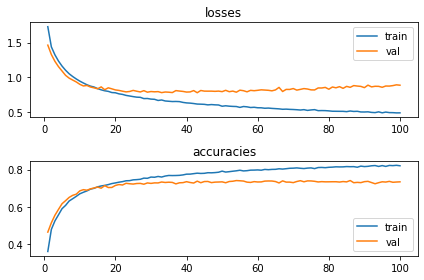

In [18]:
plot_losses(losses)

### 4.03: BatchNorm

In [19]:
class ImageClassifierNetWithBatchNorm(nn.Module):

  def __init__(self):
    super(ImageClassifierNetWithBatchNorm, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 10, 3, 1, padding=1),    # (10, 32, 32)
      nn.BatchNorm2d(10),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)                    # (10, 16, 16)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(10, 20, 3, 1, padding=1), # (20, 16, 16)
        nn.BatchNorm2d(20),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                  # (20, 8, 8)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(20, 40, 3, 1, padding=1), # (40, 8, 8)
        nn.BatchNorm2d(40),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                  # (40, 4, 4)
    )
    self.linear1 = nn.Sequential(
        nn.Linear(40 * 4 * 4, 100),
        nn.Dropout(0.2),
        nn.ReLU()
    )
    self.linear2 = nn.Linear(100, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1, 40 * 4 * 4)
    x = self.linear1(x)
    x = F.log_softmax(self.linear2(x), dim=1)
    return x

net3 = ImageClassifierNetWithBatchNorm()

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net3.to(dev)
print(net3)

ImageClassifierNetWithBatchNorm(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=640, out_features=100, bias=True)
    (1):

In [20]:
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transformations["train"])
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transformations["test"])

idx = list(range(len(train_data)))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=0)
len(train_idx), len(val_idx)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
losses = train(net3, dev, train_loader, val_loader, num_epochs=100)

EPOCH 1: train loss: 1.472, train_acc: 0.468, val loss: 1.254, val acc: 0.551
EPOCH 2: train loss: 1.156, train_acc: 0.584, val loss: 1.052, val acc: 0.626
EPOCH 3: train loss: 1.042, train_acc: 0.633, val loss: 0.985, val acc: 0.651
EPOCH 4: train loss: 0.972, train_acc: 0.658, val loss: 0.932, val acc: 0.666
EPOCH 5: train loss: 0.913, train_acc: 0.678, val loss: 0.890, val acc: 0.683
EPOCH 6: train loss: 0.885, train_acc: 0.689, val loss: 0.919, val acc: 0.684
EPOCH 7: train loss: 0.849, train_acc: 0.699, val loss: 0.870, val acc: 0.691
EPOCH 8: train loss: 0.827, train_acc: 0.708, val loss: 0.836, val acc: 0.705
EPOCH 9: train loss: 0.798, train_acc: 0.718, val loss: 0.839, val acc: 0.706
EPOCH 10: train loss: 0.787, train_acc: 0.725, val loss: 0.830, val acc: 0.710
EPOCH 11: train loss: 0.766, train_acc: 0.730, val loss: 0.782, val acc: 0.723
EPOCH 12: train loss: 0.749, train_acc: 0.736, val loss: 0.869, val acc: 0.700
EPOCH 13: train loss: 0.732, train_acc: 0.742, val loss: 0.76

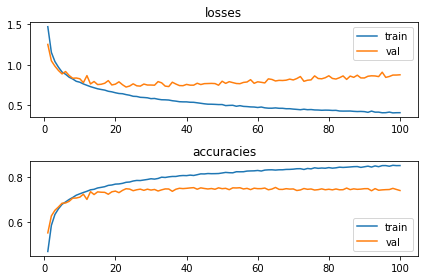

In [22]:
plot_losses(losses)

### Accuracy on test set

In [23]:
_, test_acc = evaluate(net1, dev, test_loader)
print("Test accuracy on net1: {:.5f}".format(test_acc.cpu().item()))

Test accuracy on net1: 0.68090


In [24]:
_, test_acc = evaluate(net2, dev, test_loader)
print("Test accuracy on net1: {:.5f}".format(test_acc.cpu().item()))

Test accuracy on net1: 0.73130


In [25]:
_, test_acc = evaluate(net3, dev, test_loader)
print("Test accuracy on net1: {:.5f}".format(test_acc.cpu().item()))

Test accuracy on net1: 0.73840
